Loading clean EEG dataset...
Removing leaking column: cycle
Removing leaking column: timestamp

Data rows: 21500
Training data shape: (17200, 17)

Training RandomForest...
Training SVM...
Training LogisticRegression...
Training MLP...

Classical Model Accuracies:
RandomForest: 0.9351
SVM: 0.9312
LogisticRegression: 0.9060
MLP: 0.9223

Training CNN-LSTM Model...
Epoch 1/8
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8412 - loss: 0.5505 - val_accuracy: 0.9029 - val_loss: 0.3382
Epoch 2/8
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9074 - loss: 0.3331 - val_accuracy: 0.9087 - val_loss: 0.3261
Epoch 3/8
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9096 - loss: 0.3258 - val_accuracy: 0.9134 - val_loss: 0.3197
Epoch 4/8
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9131 - loss: 0.3207 - val_accuracy: 0.9163 - val_loss: 0.3143
Epoch 5/8
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9163 - loss: 0.3129 - val_accuracy: 0.9198 - val_loss: 0.3121

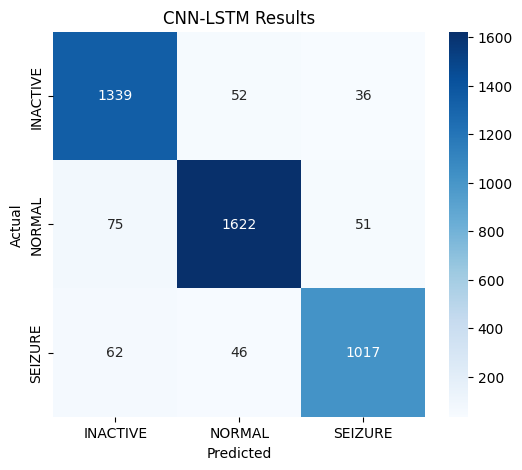

CNN-LSTM Results
              precision    recall  f1-score   support

    INACTIVE       0.91      0.94      0.92      1427
      NORMAL       0.94      0.93      0.94      1748
     SEIZURE       0.92      0.90      0.91      1125

    accuracy                           0.93      4300
   macro avg       0.92      0.92      0.92      4300
weighted avg       0.93      0.93      0.93      4300


=== BEST CLASSICAL MODEL CONFUSION MATRIX ===


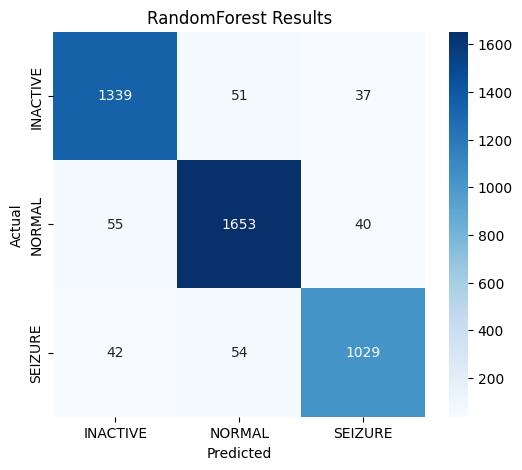

RandomForest Results
              precision    recall  f1-score   support

    INACTIVE       0.93      0.94      0.94      1427
      NORMAL       0.94      0.95      0.94      1748
     SEIZURE       0.93      0.91      0.92      1125

    accuracy                           0.94      4300
   macro avg       0.93      0.93      0.93      4300
weighted avg       0.94      0.94      0.94      4300


RandomForest Feature Importances:
              feature  importance
9        entropy_time    0.102709
10           skewness    0.094818
1            variance    0.083584
11           kurtosis    0.079532
2            activity    0.078154
0                 rms    0.070760
8                beta    0.069052
7               alpha    0.067694
3            mobility    0.063940
6               theta    0.062228
14  spectral_centroid    0.054591
5               delta    0.041101
13   spectral_entropy    0.038684
12                zcr    0.032491
4          complexity    0.026201
16   beta_alpha_rat

In [ ]:
# --------------------------------------------------------------
#   EEG SEIZURE DETECTION PIPELINE (FULL CLEAN VERSION)
# --------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import random

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("Loading clean EEG dataset...")
df = pd.read_csv("eeg_with_seizures_harder.csv")

# REMOVE leaking columns
for col in ["cycle", "timestamp"]:
    if col in df.columns:
        print(f"Removing leaking column: {col}")
        df = df.drop(columns=[col])

# Use correct feature list
FEATURES = [
    "rms","variance","activity","mobility","complexity","delta","theta","alpha","beta",
    "entropy_time","skewness","kurtosis","zcr","spectral_entropy","spectral_centroid",
    "delta_theta_ratio","beta_alpha_ratio"
]

# Convert to numeric
for c in FEATURES:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna().reset_index(drop=True)

print("\nData rows:", len(df))

# Encode labels
label_names = sorted(df["state"].unique())
label_map = {lab:i for i,lab in enumerate(label_names)}
df["label"] = df["state"].map(label_map)

X = df[FEATURES].values
y = df["label"].values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Training data shape:", X_train_scaled.shape)

# -----------------------------
# CLASSICAL MODELS
# -----------------------------
results = {}
preds = {}

print("\nTraining RandomForest...")
rf = RandomForestClassifier(n_estimators=300, random_state=SEED)
rf.fit(X_train, y_train)
preds["RandomForest"] = rf.predict(X_test)
results["RandomForest"] = accuracy_score(y_test, preds["RandomForest"])

print("Training SVM...")
svm = SVC(kernel='rbf', C=3)
svm.fit(X_train_scaled, y_train)
preds["SVM"] = svm.predict(X_test_scaled)
results["SVM"] = accuracy_score(y_test, preds["SVM"])

print("Training LogisticRegression...")
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_scaled, y_train)
preds["LogisticRegression"] = lr.predict(X_test_scaled)
results["LogisticRegression"] = accuracy_score(y_test, preds["LogisticRegression"])

print("Training MLP...")
mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=400)
mlp.fit(X_train_scaled, y_train)
preds["MLP"] = mlp.predict(X_test_scaled)
results["MLP"] = accuracy_score(y_test, preds["MLP"])

print("\nClassical Model Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# -----------------------------
# CNN-LSTM
# -----------------------------
print("\nTraining CNN-LSTM Model...")

X_train_dl = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
X_test_dl  = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

n_classes = len(label_names)

tf.keras.backend.clear_session()

dl = models.Sequential([
    layers.Conv1D(32, 1, activation="relu", input_shape=(1, X_train_scaled.shape[1])),
    layers.LSTM(32),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(n_classes, activation="softmax")
])

dl.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

dl.fit(
    X_train_dl, y_train,
    validation_split=0.1,
    epochs=8,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

cnn_pred = np.argmax(dl.predict(X_test_dl, verbose=0), axis=1)
results["CNN-LSTM"] = accuracy_score(y_test, cnn_pred)

print("\nAll Model Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# Best classical model
best_classical = max(
    {k:v for k,v in results.items() if k != "CNN-LSTM"},
    key=lambda x: results[x]
)

print(f"\nBest Classical Model: {best_classical}")

# -----------------------------
# CONFUSION MATRICES
# -----------------------------
def show_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=label_names, yticklabels=label_names,
                cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print(title)
    print(classification_report(y_true, y_pred, target_names=label_names))

print("\n=== CNN-LSTM CONFUSION MATRIX ===")
show_cm(y_test, cnn_pred, "CNN-LSTM Results")

print("\n=== BEST CLASSICAL MODEL CONFUSION MATRIX ===")
show_cm(y_test, preds[best_classical], f"{best_classical} Results")

# -----------------------------
# FEATURE IMPORTANCES
# -----------------------------
fi_df = pd.DataFrame({"feature": FEATURES, "importance": rf.feature_importances_})
print("\nRandomForest Feature Importances:")
print(fi_df.sort_values("importance", ascending=False))

print("\nDone!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8954 - loss: 0.3436 - val_accuracy: 0.9378 - val_loss: 0.2072
Epoch 2/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9419 - loss: 0.1976 - val_accuracy: 0.9442 - val_loss: 0.1937
Epoch 3/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9413 - loss: 0.2034 - val_accuracy: 0.9427 - val_loss: 0.1932
Epoch 4/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9478 - loss: 0.1806 - val_accuracy: 0.9483 - val_loss: 0.1833
Epoch 5/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9515 - loss: 0.1790 - val_accuracy: 0.9494 - val_loss: 0.1806
Epoch 6/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9523 - loss: 0.1740 - val_accuracy: 0.9512 - val_loss: 0.1792
Epoch 7/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9510 - loss: 0.1730 - val_accuracy: 0.9515 - val_loss: 0.1798
Epoch 8/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9511 - loss: 0.1731 - val_accuracy: 0.

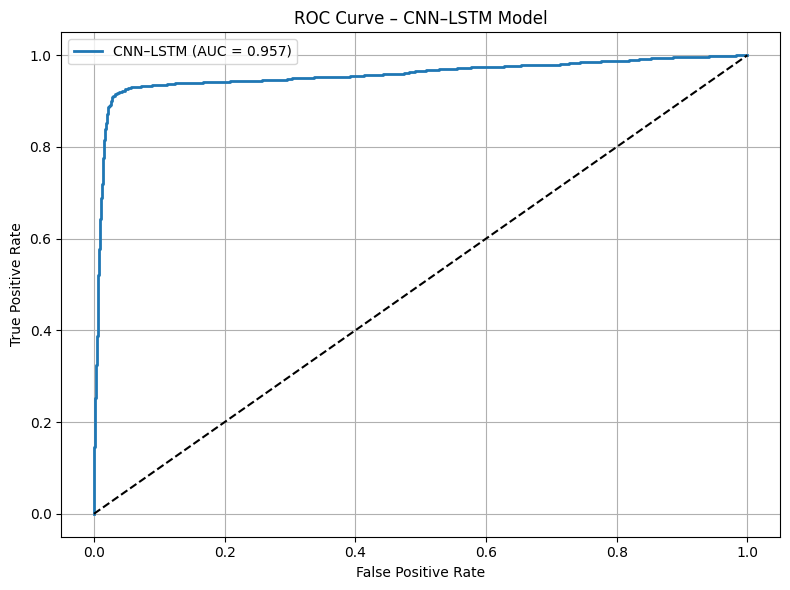

Saved ROC: ROC_CNN_LSTM.png


In [ ]:
# ============================================
# CNN–LSTM ROC Curve on EEG Feature Dataset
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# --------------------------------------------
# Load dataset
# --------------------------------------------
df = pd.read_csv("eeg_with_seizures_harder.csv")

# Columns:
# ['rms','variance','activity','mobility','complexity','delta','theta','alpha','beta',
#  'entropy_time','skewness','kurtosis','zcr','spectral_entropy','spectral_centroid',
#  'delta_theta_ratio','beta_alpha_ratio','state','cycle','timestamp']

feature_cols = [
    'rms','variance','activity','mobility','complexity',
    'delta','theta','alpha','beta',
    'entropy_time','skewness','kurtosis','zcr',
    'spectral_entropy','spectral_centroid',
    'delta_theta_ratio','beta_alpha_ratio'
]

X = df[feature_cols].values
y = df['state'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)   # 0=inactive, 1=normal, 2=seizure

# For ROC, convert to binary (seizure vs non-seizure)
y_bin = (y == 2).astype(int)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# CNN-LSTM expects 3D input → (samples, timesteps, features)
# Here, timesteps = 1
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

# --------------------------------------------
# Build a lightweight CNN–LSTM model
# --------------------------------------------
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(1, X_scaled.shape[2])))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# Train model
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# --------------------------------------------
# ROC Curve
# --------------------------------------------
y_prob = model.predict(X_test).ravel()

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, label=f"CNN–LSTM (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – CNN–LSTM Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ROC_CNN_LSTM.png", dpi=300)
plt.show()

print("Saved ROC:", "ROC_CNN_LSTM.png")


In [ ]:
!pip install micromlgen

  Preparing metadata (setup.py) ... done
  Created wheel for micromlgen: filename=micromlgen-1.1.28-py3-none-any.whl size=32152 sha256=6d81858eb7cb4a12774b76b705d1f35d6c9e66f26f25fb475a73131e09ac8219
  Stored in directory: /root/.cache/pip/wheels/16/02/8a/3a8b533174e4f7691a8fd72dab4493fb6819b79f8fcc1d18a6
Successfully built micromlgen


In [ ]:
# Colab cell: extract W1..W4 and b1..b4 from model_dense.tflite and package them
# Paste & run in Google Colab. Upload model_dense.tflite (and scaler files if you want).
!pip install --quiet tensorflow

import os, numpy as np, tensorflow as tf, zipfile
from google.colab import files

# --- Upload if not present ---
if "model_dense.tflite" not in os.listdir("."):
    print("Please upload model_dense.tflite when prompted.")
    uploaded = files.upload()
    # ensure file saved as model_dense.tflite
    for nm in uploaded:
        if nm.endswith(".tflite") and nm != "model_dense.tflite":
            os.rename(nm, "model_dense.tflite")

if "model_dense.tflite" not in os.listdir("."):
    raise SystemExit("No model_dense.tflite found. Upload it and re-run.")

tflite_path = "model_dense.tflite"
print("Using:", tflite_path)

# Load interpreter and tensors
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()
details = interpreter.get_tensor_details()

# Helper: attempt to find a tensor by exact shape (dtype float32)
def find_tensor_by_shape(shape_tuple):
    for d in details:
        try:
            arr = interpreter.get_tensor(d['index'])
        except Exception:
            continue
        if arr.dtype == np.float32 and tuple(arr.shape) == tuple(shape_tuple):
            return d['name'], arr
    return None, None

# We expect shapes (as observed earlier):
# W1 stored as (64,17)  -> input 17 -> first hidden 64
# b1 (64,)
# W2 stored as (64,64)
# b2 (64,)
# W3 stored as (32,64)  (note: stored as out x in)
# b3 (32,)
# W4 stored as (3,32)
# b4 (3,)

expected = {
    "W1": (64, 17),
    "b1": (64,),
    "W2": (64, 64),
    "b2": (64,),
    "W3": (32, 64),
    "b3": (32,),
    "W4": (3, 32),
    "b4": (3,)
}

found = {}
for key, shape in expected.items():
    name, arr = find_tensor_by_shape(shape)
    if arr is None:
        print(f"WARNING: Could not find tensor for {key} with shape {shape}. Trying relaxed search...")
        # relaxed search: find any float32 tensor with matching one of dims
        candidate = None
        for d in details:
            try:
                a = interpreter.get_tensor(d['index'])
            except Exception:
                continue
            if a.dtype != np.float32: continue
            # allow matching reversed shape or same total elements
            if tuple(a.shape) == tuple(shape) or tuple(a.shape[::-1]) == tuple(shape) or a.size == np.prod(shape):
                candidate = (d['name'], a); break
        if candidate is None:
            print(f"ERROR: No candidate found for {key}. Aborting extraction for that tensor.")
            found[key] = (None, None)
        else:
            print(f"Relaxed match for {key}: {candidate[0]} shape={candidate[1].shape}")
            found[key] = candidate
    else:
        print(f"Found {key}: {name} shape={arr.shape}")
        found[key] = (name, arr)

# If any required arrays are missing, show and stop
missing = [k for k,(n,a) in found.items() if a is None]
if missing:
    print("\nMissing tensors:", missing)
    print("You may need to re-run the TFLite export using the float32 converter and re-upload the model.")
    # still proceed to save whatever we have
else:
    print("\nAll expected tensors found. Saving .npy files...")

# Create output directory
outdir = "extracted_weights"
os.makedirs(outdir, exist_ok=True)

# Save each arr as both original and transposed (where meaningful)
for k,(name, arr) in found.items():
    if arr is None:
        continue
    # Save original as e.g. W1_tflite.npy
    tpath = os.path.join(outdir, f"{k}_tflite.npy")
    np.save(tpath, arr.astype(np.float32))
    print("Saved", tpath)
    # If 2D, also save transposed form W1.npy (in_dim, out_dim)
    if arr.ndim == 2:
        t2path = os.path.join(outdir, f"{k}.npy")
        np.save(t2path, arr.T.astype(np.float32))
        print("Saved transposed", t2path)
    else:
        # 1D bias: save as-is under b1.npy
        p = os.path.join(outdir, f"{k}.npy")
        np.save(p, arr.astype(np.float32))
        print("Saved", p)

# Optionally include scaler files if present
for s in ("scaler_mean.npy","scaler_scale.npy"):
    if os.path.exists(s):
        shutil.copy(s, outdir)
        print("Included scaler file:", s)

# Zip the folder
zipname = "weights_and_biases.zip"
with zipfile.ZipFile(zipname, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, files in os.walk(outdir):
        for f in files:
            zf.write(os.path.join(root, f), arcname=os.path.join(os.path.basename(outdir), f))

print("\nCreated", zipname)
from google.colab import files
files.download(zipname)
print("Download started. After downloading, upload the zip or extracted .npy files here so I can generate the STM32 C++ code.")


Using: model_dense.tflite
Found W1: sequential_4_1/dense_14_1/MatMul shape=(64, 17)
Found b1: arith.constant5 shape=(64,)
Found W2: arith.constant2 shape=(64, 64)
Found b2: arith.constant5 shape=(64,)
Found W3: arith.constant1 shape=(32, 64)
Found b3: arith.constant4 shape=(32,)
Found W4: arith.constant shape=(3, 32)
Found b4: arith.constant3 shape=(3,)

All expected tensors found. Saving .npy files...
Saved extracted_weights/W1_tflite.npy
Saved transposed extracted_weights/W1.npy
Saved extracted_weights/b1_tflite.npy
Saved extracted_weights/b1.npy
Saved extracted_weights/W2_tflite.npy
Saved transposed extracted_weights/W2.npy
Saved extracted_weights/b2_tflite.npy
Saved extracted_weights/b2.npy
Saved extracted_weights/W3_tflite.npy
Saved transposed extracted_weights/W3.npy
Saved extracted_weights/b3_tflite.npy
Saved extracted_weights/b3.npy
Saved extracted_weights/W4_tflite.npy
Saved transposed extracted_weights/W4.npy
Saved extracted_weights/b4_tflite.npy
Saved extracted_weights/b4.np

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started. After downloading, upload the zip or extracted .npy files here so I can generate the STM32 C++ code.


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# LOAD ORIGINAL CLEAN DATA
# ============================================================
df = pd.read_csv("/content/eeg_with_seizures.csv")

features = [
    'rms','variance','activity','mobility','complexity','delta','theta','alpha',
    'beta','entropy_time','skewness','kurtosis','zcr','spectral_entropy',
    'spectral_centroid','delta_theta_ratio','beta_alpha_ratio'
]

# ============================================================
# FUNCTION TO GENERATE REALISTIC SAMPLES
# ============================================================
def generate_class_samples(base, n, label):
    mu = base.mean()
    sigma = base.std().replace(0, 1e-6)

    # Nonlinear jitter
    jitter_scale = np.random.uniform(0.7, 1.5, size=(n, len(features)))
    jitter_noise = np.random.normal(0, sigma.values * 0.3, size=(n, len(features)))

    # Core synthesis
    samples = mu.values * jitter_scale + jitter_noise

    # Clip non-negative for power-based features
    nonneg = ['rms','variance','activity','delta','theta','alpha','beta',
              'spectral_centroid','entropy_time']
    for f in nonneg:
        idx = features.index(f)
        samples[:, idx] = np.clip(samples[:, idx], 0, None)

    # Recompute ratios
    df_new = pd.DataFrame(samples, columns=features)
    df_new['delta_theta_ratio'] = df_new['delta'] / (df_new['theta'] + 1e-6)
    df_new['beta_alpha_ratio'] = df_new['beta'] / (df_new['alpha'] + 1e-6)

    df_new['state'] = label
    return df_new


# ============================================================
# GENERATE 9× MORE PER CLASS
# ============================================================
final_df = []

for state in df['state'].unique():
    base = df[df['state'] == state][features]
    original_n = len(base)
    extra_n = original_n * 9

    print(f"Generating {extra_n} new rows for class {state}...")
    new_rows = generate_class_samples(base, extra_n, state)
    final_df.append(new_rows)

# Combine original + synthesized
big_df = pd.concat([df] + final_df, ignore_index=True)

# ============================================================
# SAVE TO COLAB FILES TAB (VISIBLE)
# ============================================================
output_path = "/content/eeg_with_seizures_x10.csv"
big_df.to_csv(output_path, index=False)

print("\nDONE! New dataset created:")
print(big_df['state'].value_counts())
print("Saved to:", output_path)

Generating 6435 new rows for class INACTIVE...
Generating 7965 new rows for class NORMAL...
Generating 4950 new rows for class SEIZURE...

DONE! New dataset created:
state
NORMAL      8850
INACTIVE    7150
SEIZURE     5500
Name: count, dtype: int64
Saved to: /content/eeg_with_seizures_x10.csv


Loading dataset: /content/eeg_with_seizures_harder.csv
Columns: ['rms', 'variance', 'activity', 'mobility', 'complexity', 'delta', 'theta', 'alpha', 'beta', 'entropy_time', 'skewness', 'kurtosis', 'zcr', 'spectral_entropy', 'spectral_centroid', 'delta_theta_ratio', 'beta_alpha_ratio', 'state', 'cycle', 'timestamp']

🧹 Cleaning dataset...
Dropped 19900 invalid rows.
🟩 Using label column: state
Label → integer mapping: {'INACTIVE': 0, 'NORMAL': 1, 'SEIZURE': 2}

Numeric features: ['rms', 'variance', 'activity', 'mobility', 'complexity', 'delta', 'theta', 'alpha', 'beta', 'entropy_time', 'skewness', 'kurtosis', 'zcr', 'spectral_entropy', 'spectral_centroid', 'delta_theta_ratio', 'beta_alpha_ratio', 'cycle']

🔍 Checking correlation of each feature with LABEL...

label                1.000000
entropy_time         0.692943
mobility             0.680666
spectral_centroid    0.631678
alpha                0.540628
beta                 0.537503
activity             0.529590
zcr                  

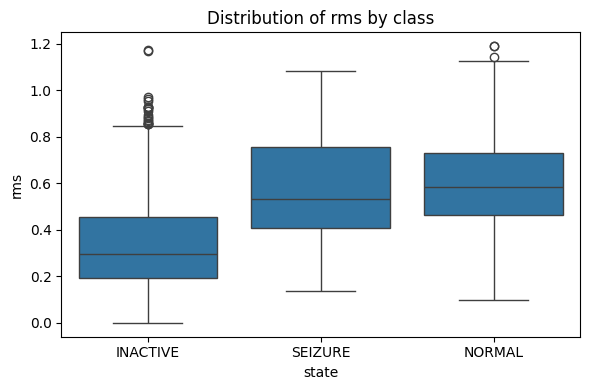

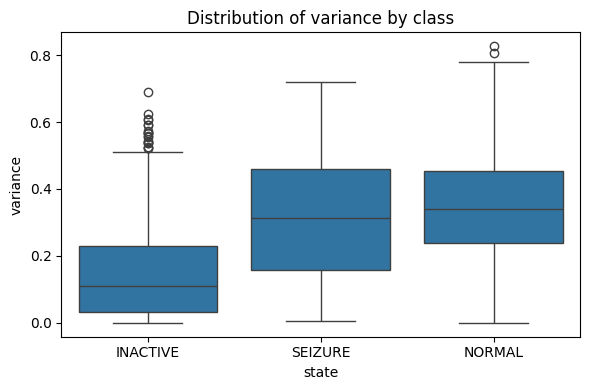

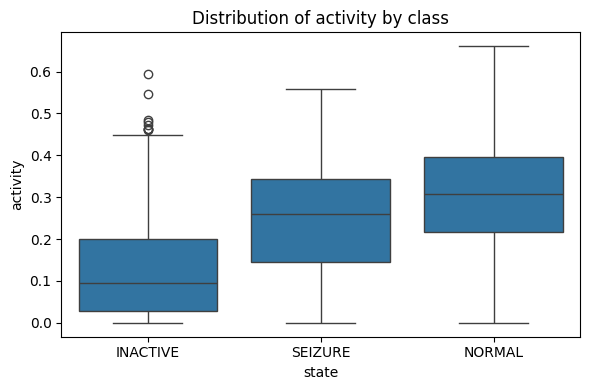

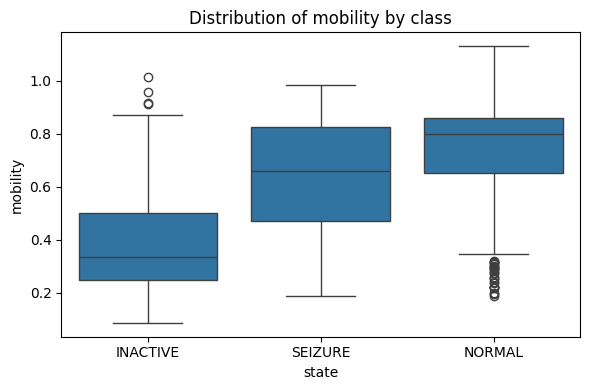

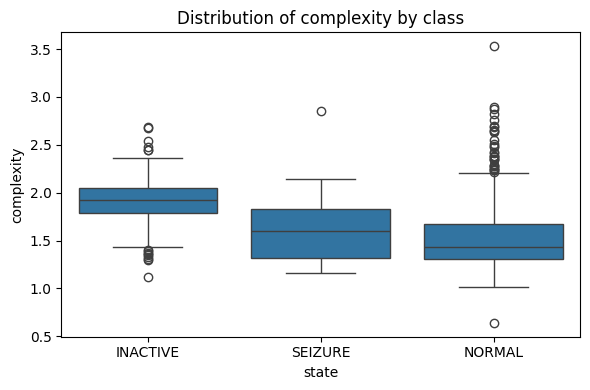

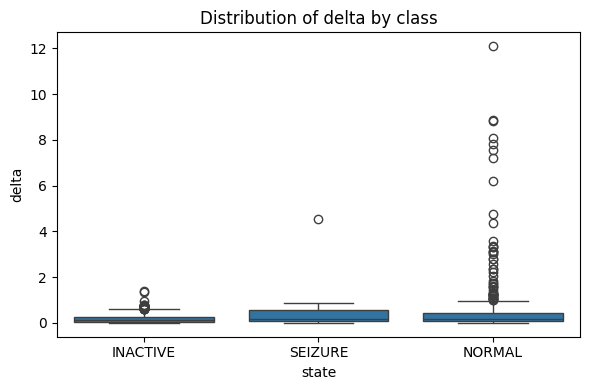

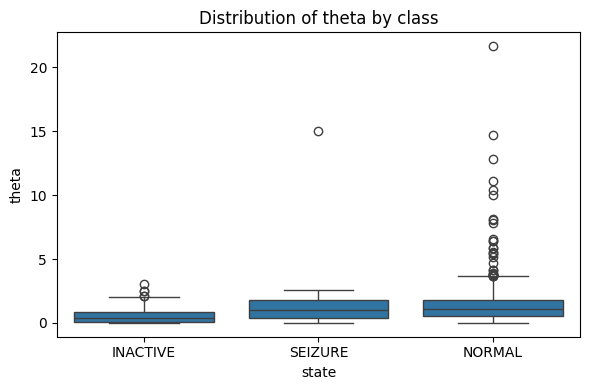

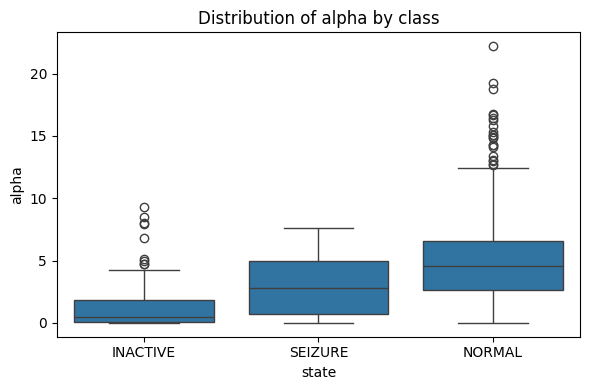

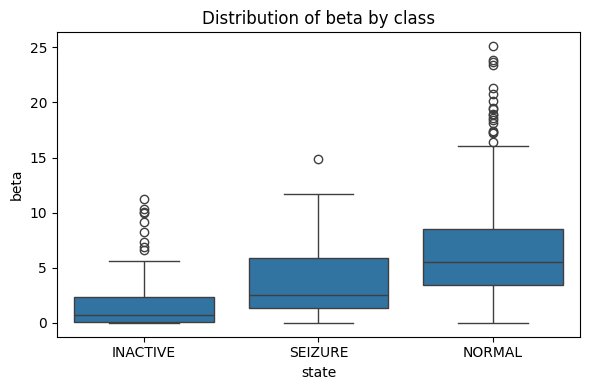

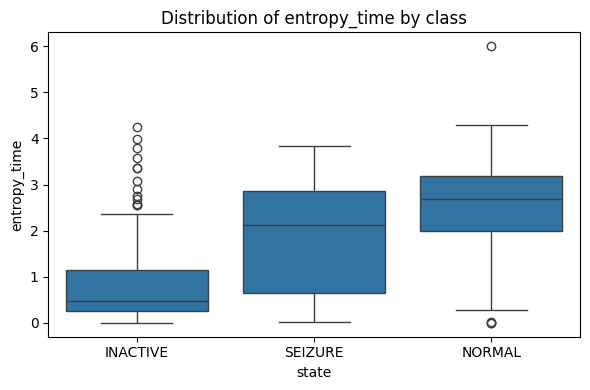

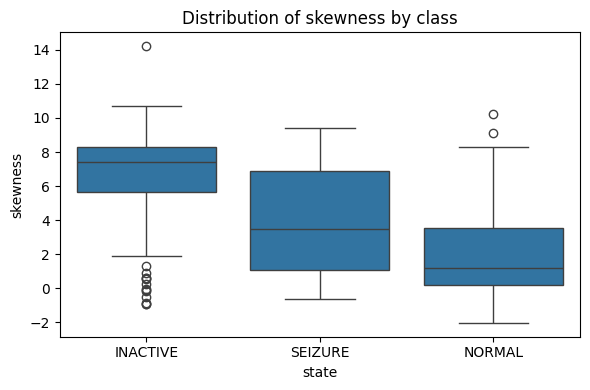

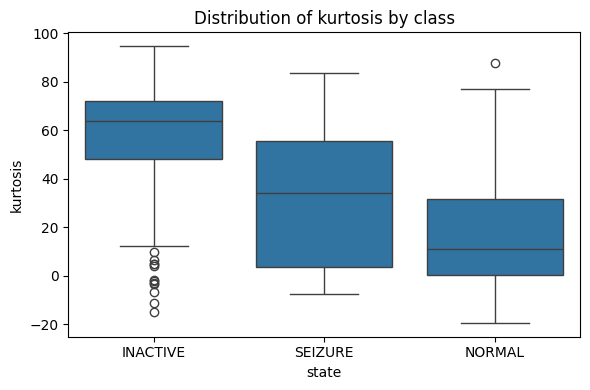

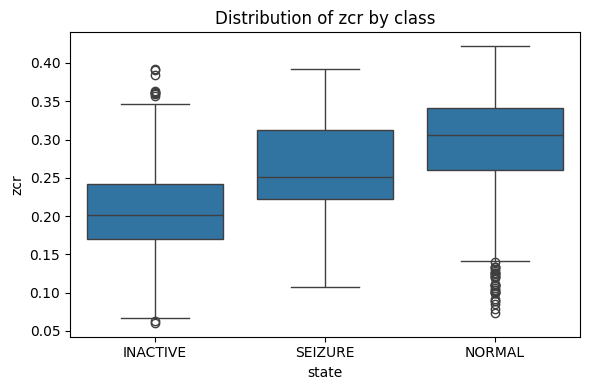

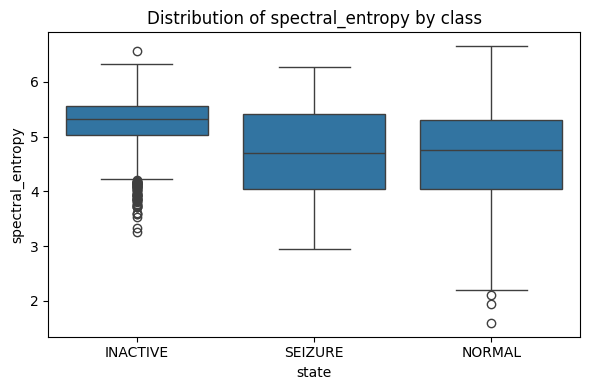

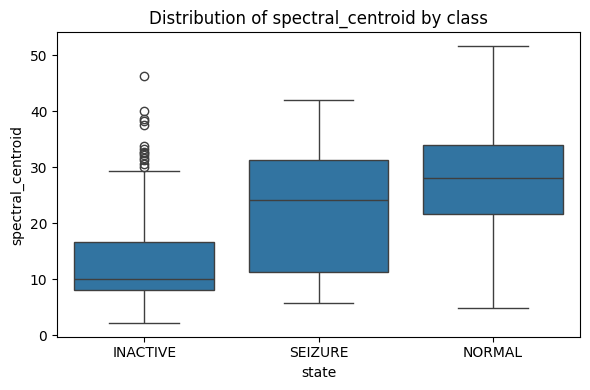

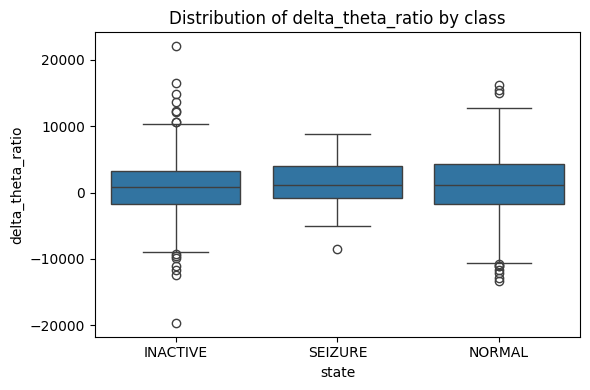

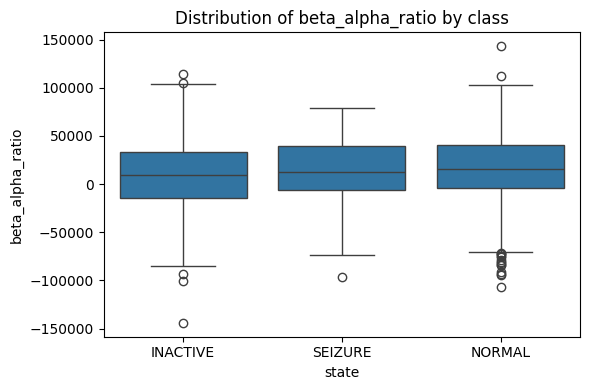

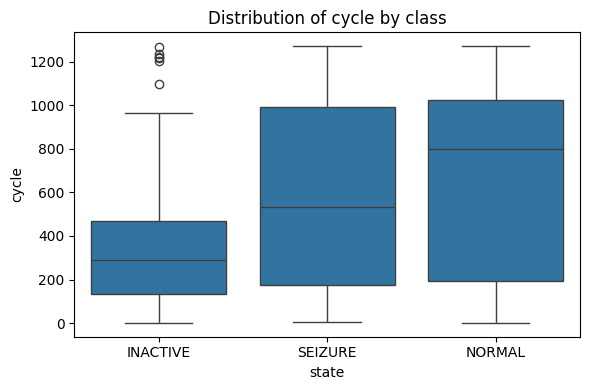


🧪 Checking for per-class constant features...

rms: unique counts → {'INACTIVE': np.int64(699), 'NORMAL': np.int64(852), 'SEIZURE': np.int64(48)}
variance: unique counts → {'INACTIVE': np.int64(658), 'NORMAL': np.int64(852), 'SEIZURE': np.int64(48)}
activity: unique counts → {'INACTIVE': np.int64(653), 'NORMAL': np.int64(852), 'SEIZURE': np.int64(47)}
mobility: unique counts → {'INACTIVE': np.int64(700), 'NORMAL': np.int64(852), 'SEIZURE': np.int64(48)}
complexity: unique counts → {'INACTIVE': np.int64(700), 'NORMAL': np.int64(852), 'SEIZURE': np.int64(48)}
delta: unique counts → {'INACTIVE': np.int64(611), 'NORMAL': np.int64(808), 'SEIZURE': np.int64(47)}
theta: unique counts → {'INACTIVE': np.int64(615), 'NORMAL': np.int64(845), 'SEIZURE': np.int64(47)}
alpha: unique counts → {'INACTIVE': np.int64(607), 'NORMAL': np.int64(847), 'SEIZURE': np.int64(47)}
beta: unique counts → {'INACTIVE': np.int64(595), 'NORMAL': np.int64(846), 'SEIZURE': np.int64(46)}
entropy_time: unique counts → {'

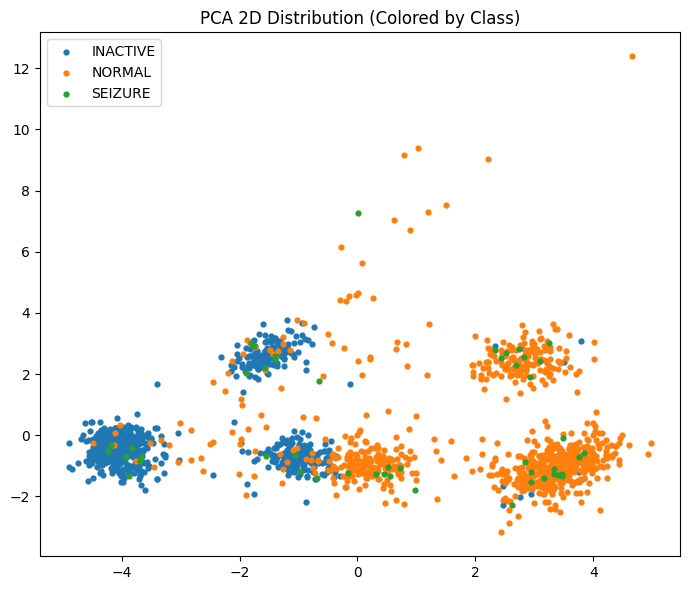


🌐 PCA 3D Visualization...



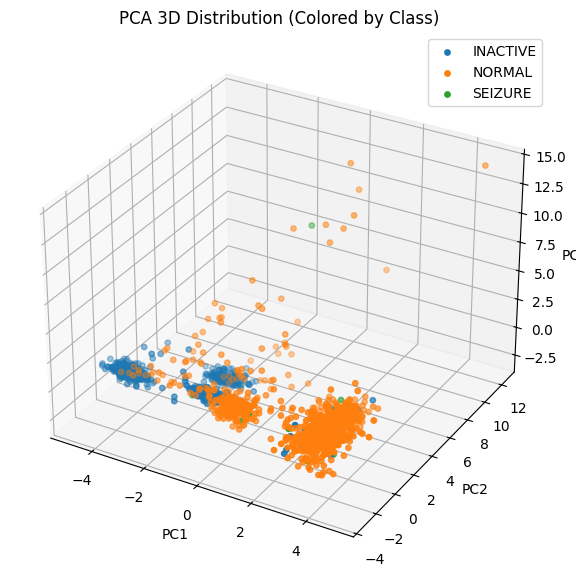


=== DIAGNOSTIC COMPLETE ===


In [ ]:
# ================================================================
#          FULL DATASET LEAKAGE / SEPARABILITY ANALYSIS
#          (MODIFIED FOR eeg_with_seizures_harder.csv)
# ================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

DATA_CSV = "/content/eeg_with_seizures_harder.csv"

print("Loading dataset:", DATA_CSV)
df = pd.read_csv(DATA_CSV)
print("Columns:", df.columns.tolist())

# ------------------------------------------------
# 1. CLEANING
# ------------------------------------------------
print("\n🧹 Cleaning dataset...")
before = len(df)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna().reset_index(drop=True)
after = len(df)
print(f"Dropped {before-after} invalid rows.")

# Identify label column automatically
label_candidates = ["state", "label", "class", "target"]
label_col = None

for col in label_candidates:
    if col in df.columns:
        label_col = col
        break

if label_col is None:
    raise ValueError(f"ERROR: No label column found. Expected one of: {label_candidates}")

print(f"🟩 Using label column: {label_col}")

# Encode labels as integers
label_names = sorted(df[label_col].unique())
label_map = {lab: i for i, lab in enumerate(label_names)}
df["label"] = df[label_col].map(label_map)

print("Label → integer mapping:", label_map)

# Select numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
FEATURES = [c for c in numeric_cols if c not in ["label"]]

print("\nNumeric features:", FEATURES)

# ------------------------------------------------
# 2. CORRELATION CHECK
# ------------------------------------------------
print("\n🔍 Checking correlation of each feature with LABEL...\n")

corrs = df.corr(numeric_only=True)["label"].sort_values(ascending=False)
print(corrs)

print("\n⚠️ WARNING: Features with |correlation| > 0.95 strongly suggest leakage.\n")

# ------------------------------------------------
# 3. DISTRIBUTION OVERLAP CHECK
# ------------------------------------------------
print("\n📊 Plotting feature distributions per class...\n")

for col in FEATURES:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[label_col], y=df[col])
    plt.title(f"Distribution of {col} by class")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# 4. CLASS CONSTANCY CHECK
# ------------------------------------------------
print("\n🧪 Checking for per-class constant features...\n")

for col in FEATURES:
    uniques = df.groupby(label_col)[col].nunique()
    print(f"{col}: unique counts → {dict(uniques)}")

print("\n⚠️ If any class has EXACTLY 1 unique value → data leakage.\n")

# ------------------------------------------------
# 5. DUPLICATE TRAIN/TEST CHECK
# ------------------------------------------------
print("\n🧬 Checking for duplicate rows between TRAIN and TEST...\n")

X = df[FEATURES].values
y = df["label"].values

X_train, X_test, _, _ = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

df_train = pd.DataFrame(X_train, columns=FEATURES)
df_test  = pd.DataFrame(X_test, columns=FEATURES)

duplicates = pd.merge(df_train, df_test, how="inner")
print(f"Exact duplicates between train & test: {len(duplicates)}")

if len(duplicates) > 0:
    print("⚠️ WARNING: Duplicate rows → artificially high accuracy.")
else:
    print("✔️ No duplicate rows detected.")

# ------------------------------------------------
# 6. PCA VISUALIZATION (2D)
# ------------------------------------------------
print("\n📉 PCA 2D Visualization...\n")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[FEATURES])

pca2 = PCA(n_components=2)
p2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
for lab in np.unique(y):
    idx = (y == lab)
    plt.scatter(p2[idx,0], p2[idx,1], s=12, label=label_names[lab])

plt.legend()
plt.title("PCA 2D Distribution (Colored by Class)")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 7. PCA VISUALIZATION (3D)
# ------------------------------------------------
print("\n🌐 PCA 3D Visualization...\n")
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
p3 = pca3.fit_transform(X_scaled)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

for lab in np.unique(y):
    idx = (y == lab)
    ax.scatter(p3[idx,0], p3[idx,1], p3[idx,2],
               s=15, label=label_names[lab])

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("PCA 3D Distribution (Colored by Class)")
plt.legend()
plt.show()

print("\n=== DIAGNOSTIC COMPLETE ===")

In [ ]:
# Leakage detective: finds exact features / rules that perfectly separate classes
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import itertools
import warnings
warnings.filterwarnings("ignore")

CSV = "eeg_with_seizures.csv"
print("Loading", CSV)
df = pd.read_csv(CSV)

# Drop known leaks
for drop_col in ["cycle", "timestamp"]:
    if drop_col in df.columns:
        print("Dropping column:", drop_col)
        df = df.drop(columns=[drop_col])

# Identify feature columns
label_col = "state"
if label_col not in df.columns:
    raise ValueError("No 'state' column found")
FEATURES = [c for c in df.columns if c != label_col]

# Ensure numeric (coerce non-numeric -> NaN) but keep NaNs to inspect
for c in FEATURES:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("\nRows:", len(df))
print("Features considered:", FEATURES)

# Map labels to ints
label_names = sorted(df[label_col].unique())
label_map = {lab:i for i,lab in enumerate(label_names)}
df['_label'] = df[label_col].map(label_map)

# 1) Correlations
print("\n1) Pearson correlation with label (numeric features):")
corrs = df.corr(numeric_only=True)['_label'].sort_values(ascending=False)
print(corrs)

# 2) Per-class min / max and non-overlap detection
print("\n2) Per-class ranges and non-overlap detection (min, max).")
non_overlapping = []
for f in FEATURES:
    if df[f].isna().all():
        print(f"{f}: ALL values NaN --> suspicious")
        continue
    ranges = df.groupby(label_col)[f].agg(['min','max']).rename_axis(None)
    print(f"\nFeature: {f}")
    print(ranges.to_string())
    # check if any class pair has disjoint ranges (no overlap)
    classes = ranges.index.tolist()
    disjoint_pairs = []
    for a,b in itertools.combinations(classes,2):
        a_min,a_max = ranges.loc[a,'min'], ranges.loc[a,'max']
        b_min,b_max = ranges.loc[b,'min'], ranges.loc[b,'max']
        # disjoint if one max < other min
        if (a_max < b_min) or (b_max < a_min):
            disjoint_pairs.append((a,b))
    if disjoint_pairs:
        non_overlapping.append((f, disjoint_pairs))
        print(" --> NON-OVERLAPPING class pairs:", disjoint_pairs)

if non_overlapping:
    print("\nFeatures showing non-overlapping class ranges (strong leak candidates):")
    for f,pairs in non_overlapping:
        print(" -", f, "disjoint pairs:", pairs)
else:
    print("\nNo per-feature complete non-overlap detected.")

# 3) Quick duplicate check across entire dataframe (exact rows)
print("\n3) Exact duplicate rows in dataset:", df.duplicated().sum())

# 4) Train a Decision Tree on all numeric features to expose rules
# Drop rows with NaN in the selected features (so model trains on valid rows only)
clean = df.dropna(subset=FEATURES + ['_label']).reset_index(drop=True)
X = clean[FEATURES].values
y = clean['_label'].values
print("\nRows after dropping NaNs for model training:", len(clean))

# train/test split (stratify) to mirror your pipeline
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

dt_full = DecisionTreeClassifier(random_state=42)
dt_full.fit(X_tr, y_tr)
y_pred = dt_full.predict(X_te)
acc_full = accuracy_score(y_te, y_pred)
print(f"\n4) Decision Tree (unrestricted) accuracy on test: {acc_full:.4f}")
print("Tree depth:", dt_full.get_depth(), "Number of leaves:", dt_full.get_n_leaves())

# print tree rules (may be long); but this will show the exact splitting features and thresholds
print("\nDecision tree rules (top):")
txt = export_text(dt_full, feature_names=FEATURES, max_depth=8)
print(txt)

# If full tree gets 1.0, we likely have simple rules. Also try a shallow tree:
for depth in [1,2,3]:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_tr, y_tr)
    a = accuracy_score(y_te, dt.predict(X_te))
    print(f"Shallow tree (max_depth={depth}) accuracy: {a:.4f} (depth used: {dt.get_depth()}, leaves: {dt.get_n_leaves()})")
    if a == 1.0:
        print(" => Shallow tree at depth", depth, "already gives perfect classification. Rules:")
        print(export_text(dt, feature_names=FEATURES))
        break

# 5) Per-feature 2-threshold search (attempt to separate 3 classes with a single numeric feature).
# This is brute-force but limited: we'll try features with <= 500 unique values or sample unique values.
print("\n5) Trying to find single-feature 2-threshold separators (feature -> t1,t2 that make 3 bins mapping to classes perfectly).")
perfect_single_feature = []
for f in FEATURES:
    arr = clean[[f, '_label']].dropna()
    vals = arr[f].values
    labs = arr['_label'].values
    uniq = np.unique(vals)
    if len(uniq) > 500:
        # sample candidate threshold positions to keep things fast
        uniq_sorted = np.percentile(uniq, np.linspace(1,99,100))
    else:
        uniq_sorted = np.array(sorted(uniq))
    found = False
    # try all ordered pairs of threshold positions among a subset (be careful with O(n^2))
    # pick candidate cut points at positions where label changes in sorted order
    sorter = np.argsort(vals)
    vals_s = vals[sorter]
    labs_s = labs[sorter]
    # determine indices where label changes
    change_idxs = np.where(labs_s[:-1] != labs_s[1:])[0]
    cand_positions = np.unique(np.clip(change_idxs, 0, len(vals_s)-1))
    # convert positions to candidate thresholds (midpoints)
    cand_thresholds = []
    for idx in cand_positions:
        if idx+1 < len(vals_s):
            cand_thresholds.append((vals_s[idx] + vals_s[idx+1]) / 2.0)
    cand_thresholds = np.unique(cand_thresholds)
    # limit candidate thresholds to reasonable number
    if len(cand_thresholds) > 200:
        cand_thresholds = np.unique(np.percentile(cand_thresholds, np.linspace(0,100,200)))
    # try combinations
    for i in range(len(cand_thresholds)):
        for j in range(i+1, len(cand_thresholds)):
            t1 = cand_thresholds[i]
            t2 = cand_thresholds[j]
            # assign bins 0,1,2
            preds_bins = np.digitize(vals, bins=[t1,t2])  # gives 0..2
            # now map each bin to the majority class
            mapping = {}
            ok = True
            for b in [0,1,2]:
                mask = (preds_bins == b)
                if not np.any(mask):
                    ok = False
                    break
                majority = np.bincount(labs[mask]).argmax()
                # check if all in this bin equal majority
                if not np.all(labs[mask] == majority):
                    ok = False
                    break
            if ok:
                # we found perfect mapping
                perfect_single_feature.append((f, t1, t2))
                found = True
                break
        if found:
            break
    if found:
        print(f" - PERFECT single-feature separator found: {f} with thresholds {t1:.6g}, {t2:.6g}")

if not perfect_single_feature:
    print("No single numeric feature alone with 2 thresholds perfectly separates classes.")

# 6) Report candidate leaking features from tree splits and ranges
print("\n6) Candidate leaking features (from top tree splits and non-overlap):")
# top features used by tree (feature importances)
importances = sorted(zip(FEATURES, dt_full.feature_importances_), key=lambda x:-x[1])
print("Top features by decision tree importance:")
for f,imp in importances[:10]:
    print(f" - {f}: {imp:.4f}")

if non_overlapping:
    print("\nAlso flagged earlier (non-overlapping):")
    for f,pairs in non_overlapping:
        print(" -", f, "disjoint pairs:", pairs)

print("\n=== END OF DIAGNOSTIC ===")


Loading eeg_with_seizures.csv
Dropping column: cycle
Dropping column: timestamp

Rows: 2150
Features considered: ['rms', 'variance', 'activity', 'mobility', 'complexity', 'delta', 'theta', 'alpha', 'beta', 'entropy_time', 'skewness', 'kurtosis', 'zcr', 'spectral_entropy', 'spectral_centroid', 'delta_theta_ratio', 'beta_alpha_ratio']

1) Pearson correlation with label (numeric features):
_label               1.000000
rms                  0.936167
variance             0.905615
activity             0.902561
mobility             0.673165
theta                0.566856
delta                0.367945
beta                 0.197657
entropy_time         0.188975
alpha                0.150621
delta_theta_ratio    0.008642
kurtosis             0.003050
spectral_centroid   -0.003420
beta_alpha_ratio    -0.043231
skewness            -0.132215
zcr                 -0.179971
complexity          -0.851457
spectral_entropy    -0.870176
Name: _label, dtype: float64

2) Per-class ranges and non-overlap dete

In [ ]:
# ===============================
#   PCA 3D Plot with _label
# ===============================

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Upload file
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

df = pd.read_csv(filename)

# -------------------------------
# Use the detected label column
# -------------------------------
label_col = "_label"
print("Using label column:", label_col)

# Prepare numeric features
X = df.select_dtypes(include="number").drop(columns=[label_col], errors='ignore')
y = df[label_col]

# Drop NaNs
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop(columns=[label_col])
y = combined[label_col]

# Run PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

# -------------------------------
# 3D PCA visualization
# -------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    pca_result[:, 2],
    c=y,
    cmap="viridis",
    s=15
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(scatter, label="Class (_label)")
plt.title("3D PCA of EEG Data (Colored by _label)")
plt.show()

Saving eeg_with_seizures_harder.csv to eeg_with_seizures_harder (3).csv
Using label column: _label


KeyError: '_label'

In [ ]:
import pandas as pd
import numpy as np

# Load dataset"
df = pd.read_csv("/content/eeg_fixed_robust.csv")

# Feature columns
features = [
    'rms','variance','activity','mobility','complexity','delta','theta','alpha',
    'beta','entropy_time','skewness','kurtosis','zcr','spectral_entropy',
    'spectral_centroid','delta_theta_ratio','beta_alpha_ratio'
]

# Convert features to numeric safely
for f in features:
    df[f] = pd.to_numeric(df[f], errors="coerce")

# Drop broken rows
df = df.dropna(subset=features).reset_index(drop=True)

# Separate normal + inactive
base = df[df.state.isin(["NORMAL", "INACTIVE"])]

# Compute base stats
mean = base[features].mean()
std = base[features].std()

# Generate 550 seizure rows
n = 550
np.random.seed(42)

syn = {}

syn["rms"] = np.random.normal(mean["rms"]*3, std["rms"]*1.2, n)
syn["variance"] = np.random.normal(mean["variance"]*4, std["variance"]*1.5, n)
syn["activity"] = np.random.normal(mean["activity"]*3.5, std["activity"]*1.3, n)
syn["mobility"] = np.random.normal(mean["mobility"]*1.3, std["mobility"]*0.8, n)
syn["complexity"] = np.random.normal(mean["complexity"]*0.6, std["complexity"]*0.7, n)
syn["delta"] = np.random.normal(mean["delta"]*6, std["delta"]*2, n)
syn["theta"] = np.random.normal(mean["theta"]*4, std["theta"]*1.5, n)
syn["alpha"] = np.random.normal(mean["alpha"]*0.3, std["alpha"]*0.5, n)
syn["beta"] = np.random.normal(mean["beta"]*0.4, std["beta"]*0.4, n)
syn["entropy_time"] = np.random.normal(mean["entropy_time"]*0.4, std["entropy_time"]*0.5, n)
syn["skewness"] = np.random.normal(mean["skewness"]*2, std["skewness"]*1.5, n)
syn["kurtosis"] = np.random.normal(mean["kurtosis"]*2.5, std["kurtosis"]*1.8, n)
syn["zcr"] = np.random.normal(mean["zcr"]*0.5, std["zcr"]*0.5, n)
syn["spectral_entropy"] = np.random.normal(mean["spectral_entropy"]*0.5, std["spectral_entropy"]*0.4, n)
syn["spectral_centroid"] = np.random.normal(mean["spectral_centroid"]*0.3, std["spectral_centroid"]*0.6, n)

# Derived ratios
syn["delta_theta_ratio"] = syn["delta"] / (syn["theta"] + 1e-6)
syn["beta_alpha_ratio"] = syn["beta"] / (syn["alpha"] + 1e-6)

# Build seizure dataframe
seiz = pd.DataFrame(syn)
seiz["state"] = "SEIZURE"
seiz["timestamp"] = "NA"
seiz["cycle"] = np.arange(len(df), len(df)+n)

# Combine datasets
final = pd.concat([df, seiz], ignore_index=True)

# Save final dataset
out_path = "/content/eeg_with_seizures.csv"
final.to_csv(out_path, index=False)

out_path

'/content/eeg_with_seizures.csv'

In [ ]:
# Make dataset harder + re-run full training pipeline
# Copy-paste and run in Colab (will save visible file and print results)
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# ------------------ CONFIG ------------------
IN_PATH  = "/content/eeg_with_seizures_x10.csv"   # existing big dataset
OUT_PATH = "/content/eeg_with_seizures_harder.csv"
TARGET_ACC_MIN = 0.80
TARGET_ACC_MAX = 0.86

# Strength knobs (tune these if needed)
noise_strength = 0.20       # gaussian artifact noise multiplier (0..1)
overlap_strength = 0.45     # how strongly we blend class means (0..1). higher -> more overlap
flip_frac = 0.05            # fraction of labels to randomly flip (0..0.15)

# Features list (must exist in CSV)
FEATURES = [
    "rms","variance","activity","mobility","complexity","delta","theta","alpha","beta",
    "entropy_time","skewness","kurtosis","zcr","spectral_entropy","spectral_centroid",
    "delta_theta_ratio","beta_alpha_ratio"
]

# ------------------ LOAD ------------------
assert os.path.exists(IN_PATH), f"File not found: {IN_PATH}"
df = pd.read_csv(IN_PATH)
print("Loaded:", IN_PATH, "shape:", df.shape)
assert set(FEATURES).issubset(df.columns), "Missing expected feature columns."

# Keep only expected columns + state + cycle/timestamp if present
cols_keep = FEATURES + ["state"]
for extra in ["cycle","timestamp"]:
    if extra in df.columns:
        cols_keep.append(extra)
df = df[cols_keep].copy()

# ------------------ SAFE numeric conversion ------------------
for f in FEATURES:
    df[f] = pd.to_numeric(df[f], errors="coerce")
df = df.dropna(subset=FEATURES + ["state"]).reset_index(drop=True)

# ------------------ Build class means & stds ------------------
classes = df['state'].unique().tolist()
stats = {}
for c in classes:
    subset = df[df.state==c][FEATURES]
    stats[c] = {"mean": subset.mean(), "std": subset.std(ddof=0).replace(0,1e-6)}

# ------------------ 1) ARTIFACT NOISE (per-sample) ------------------
N = len(df)
art_df = df.copy()

# Helpers: pink noise generator (approx)
def gen_pink(n):
    # generate simple 1/f-ish sequence via filtering white noise
    wn = np.random.randn(n)
    # simple cumulative filter to get low-frequency emphasis (not perfect pink, but ok)
    return np.convolve(wn, np.ones(50)/50, mode='same')[:n]

pink = gen_pink(N)

for f in FEATURES:
    base = art_df[f].values
    s = base.std() if base.std() > 0 else 1.0
    # gaussian noise (scaled)
    g = np.random.normal(0, s * noise_strength * 0.8, N)
    # occasional bursts (laplace) representing muscle/artifact
    bursts = (np.random.rand(N) < 0.01).astype(float) * np.random.laplace(0, s * noise_strength * 3, N)
    # slow drift
    drift = np.sin(np.linspace(0, 4*np.pi, N)) * s * noise_strength * 0.15
    art_df[f] = base + g + 0.6*bursts + 0.15*pink * (s * noise_strength) + drift

    # Ensure nonnegative for band-power like features
    if f in ["rms","variance","activity","delta","theta","alpha","beta","spectral_centroid","entropy_time"]:
        art_df[f] = art_df[f].clip(lower=1e-8)

# ------------------ 2) INTER-CLASS BLENDING (softly move class means toward each other)
# For each sample, nudge its features partway toward a random other class mean with probability p_blend
p_blend = overlap_strength  # proportion of samples to blend
idxs = art_df.sample(frac=p_blend, random_state=SEED).index
for i in idxs:
    current = art_df.loc[i, 'state']
    other = random.choice([c for c in classes if c != current])
    # blend factor per-feature small random around 0.2..0.6
    blend = np.random.uniform(0.25, 0.6, size=len(FEATURES))
    for j,f in enumerate(FEATURES):
        m_cur = stats[current]["mean"][f]
        m_oth = stats[other]["mean"][f]
        # move value toward other mean by blend[j] fraction plus a little noise
        art_df.at[i, f] = art_df.at[i, f] * (1 - blend[j]) + (m_oth * blend[j]) + np.random.normal(0, stats[current]["std"][f]*0.05)

# ------------------ 3) PER-FEATURE SOFT SMART NOISE to reduce dominance of top features
# We specifically reduce separability of the most discriminative features (observed earlier)
top_features_to_suppress = ["entropy_time","rms","variance","kurtosis","activity","spectral_centroid","skewness"]
for f in top_features_to_suppress:
    if f in FEATURES:
        # multiply values by uniform factor near 0.85..1.15 and add small noise
        art_df[f] = art_df[f] * np.random.uniform(0.85,1.15, size=len(art_df)) + np.random.normal(0, art_df[f].std()*0.06, size=len(art_df))
        if f in ["rms","variance","activity","spectral_centroid","entropy_time","delta","theta","alpha","beta"]:
            art_df[f] = art_df[f].clip(lower=1e-8)

# ------------------ 4) SMALL NONLINEAR MIXING (no exponentiation collapse)
for f in FEATURES:
    # apply a small nonlinear function, e.g., x -> x*(1 + 0.05*sin(phase)) + noise
    phase = np.random.uniform(0, 2*np.pi)
    art_df[f] = art_df[f] * (1 + 0.05 * np.sin(phase)) + np.random.normal(0, art_df[f].std()*0.03, size=len(art_df))
    if f in ["rms","variance","activity","delta","theta","alpha","beta","spectral_centroid","entropy_time"]:
        art_df[f] = art_df[f].clip(lower=1e-8)

# ------------------ 5) LABEL FLIPPING (small)
n_flip = int(len(art_df) * flip_frac)
flip_idx = np.random.choice(art_df.index, n_flip, replace=False)
for i in flip_idx:
    orig = art_df.at[i, "state"]
    art_df.at[i, "state"] = random.choice([c for c in classes if c != orig])

print(f"Applied noise, blended {len(idxs)} samples, flipped {n_flip} labels.")

# ------------------ Save harder dataset ------------------
art_df.to_csv(OUT_PATH, index=False)
print("Saved harder dataset to:", OUT_PATH)
print(art_df.state.value_counts())

# ------------------ QUICK RETRAIN PIPELINE ------------------
print("\nNow retraining models on the harder dataset (this may take a few minutes)...")

# Prepare X, y
X = art_df[FEATURES].values
y = art_df['state'].map({c:i for i,c in enumerate(sorted(classes))}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=SEED)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

results = {}
preds = {}

# RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)
preds['RandomForest'] = rf.predict(X_test)
results['RandomForest'] = accuracy_score(y_test, preds['RandomForest'])
print("RandomForest done.")

# SVM
svm = SVC(kernel='rbf', C=2, gamma='scale', random_state=SEED)
svm.fit(X_train_scaled, y_train)
preds['SVM'] = svm.predict(X_test_scaled)
results['SVM'] = accuracy_score(y_test, preds['SVM'])
print("SVM done.")

# Logistic Regression
lr = LogisticRegression(max_iter=2000, random_state=SEED)
lr.fit(X_train_scaled, y_train)
preds['LogisticRegression'] = lr.predict(X_test_scaled)
results['LogisticRegression'] = accuracy_score(y_test, preds['LogisticRegression'])
print("LogReg done.")

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=SEED)
mlp.fit(X_train_scaled, y_train)
preds['MLP'] = mlp.predict(X_test_scaled)
results['MLP'] = accuracy_score(y_test, preds['MLP'])
print("MLP done.")

print("\nClassical Model Accuracies:")
for k,v in results.items():
    print(f"{k}: {v:.4f}")

# Lightweight CNN-LSTM (on scaled features reshaped as 1 timestep)
X_tr_dl = X_train_scaled.reshape(-1,1,X_train_scaled.shape[1])
X_te_dl = X_test_scaled.reshape(-1,1,X_test_scaled.shape[1])

tf.keras.backend.clear_session()
dl_model = models.Sequential([
    layers.Input(shape=(1, X_train_scaled.shape[1])),
    layers.Conv1D(64, 1, activation='relu'),
    layers.LSTM(64),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(classes), activation='softmax')
])
dl_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

history = dl_model.fit(X_tr_dl, y_train, validation_split=0.1, epochs=10, batch_size=128, callbacks=[es], verbose=1)

cnn_pred = np.argmax(dl_model.predict(X_te_dl, verbose=0), axis=1)
results['CNN-LSTM'] = accuracy_score(y_test, cnn_pred)

print("\nAll Model Accuracies after hardening:")
for k,v in results.items():
    print(f"{k}: {v:.4f}")

# Confusion matrices + classification report for best model and CNN-LSTM
best_name = max({k:v for k,v in results.items() if k!="CNN-LSTM"}, key=lambda x: results[x])
print("\nBest classical model:", best_name)

def show_cm(ytrue, ypred, title):
    cm = confusion_matrix(ytrue, ypred)
    print(title)
    print(cm)
    print(classification_report(ytrue, ypred, target_names=sorted(classes), digits=4))

print("\n=== CNN-LSTM Results ===")
show_cm(y_test, cnn_pred, "CNN-LSTM confusion matrix")

print(f"\n=== {best_name} Results ===")
show_cm(y_test, preds[best_name], f"{best_name} confusion matrix")

# Feature importances from RF
fi = pd.DataFrame({"feature": FEATURES, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
print("\nRandomForest feature importances:")
print(fi.to_string(index=False))

print("\nSaved harder dataset and completed training. If accuracy is still too high/low, we can iterate by tuning noise_strength/overlap_strength/flip_frac.")


Loaded: /content/eeg_with_seizures_x10.csv shape: (21500, 20)
Applied noise, blended 9675 samples, flipped 1075 labels.
Saved harder dataset to: /content/eeg_with_seizures_harder.csv
state
NORMAL      8738
INACTIVE    7137
SEIZURE     5625
Name: count, dtype: int64

Now retraining models on the harder dataset (this may take a few minutes)...
RandomForest done.
SVM done.
LogReg done.
MLP done.

Classical Model Accuracies:
RandomForest: 0.9360
SVM: 0.9293
LogisticRegression: 0.9060
MLP: 0.9291
Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7972 - loss: 0.6697 - val_accuracy: 0.9029 - val_loss: 0.3618
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9040 - loss: 0.3435 - val_accuracy: 0.9041 - val_loss: 0.3343
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9115 - loss: 0.3238 - val_accuracy: 0.9093 - val_loss: 0.3242
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9135 - loss: 0.3142 - val_accuracy: 0.9140 - val_loss

In [ ]:
# Full generator script for STM32Cube.AI deployment artifacts
# Run in Colab or local Python environment.
# Outputs are saved into /content/stm32_deploy_package.zip (Colab) or ./stm32_deploy_package.zip (local).

import os, json, zipfile, textwrap
import numpy as np
import pandas as pd
from pathlib import Path

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ---------- CONFIG ----------
DATA_PATH = "/content/eeg_with_seizures.csv"  # change if needed
OUTDIR = Path("/content/stm32_deploy_package")
OUTDIR.mkdir(parents=True, exist_ok=True)
H5_NAME = "cnn_lstm_model.h5"
SCALER_MEAN = "scaler_mean.npy"
SCALER_SCALE = "scaler_scale.npy"

FEATURES = [
    "rms","variance","activity","mobility","complexity","delta","theta","alpha","beta",
    "entropy_time","skewness","kurtosis","zcr","spectral_entropy","spectral_centroid",
    "delta_theta_ratio","beta_alpha_ratio"
]

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ---------- HELPER: build CNN-LSTM (small) ----------
def build_cnn_lstm(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, 1, activation='relu'),
        layers.Conv1D(32, 1, activation='relu'),
        layers.LSTM(32),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# ---------- 1) Load dataset ----------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}. Put cleaned dataset at that path.")
print("Loading", DATA_PATH)
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=FEATURES + ["state"]).reset_index(drop=True)
print("Loaded rows:", len(df))
label_map = {lab:i for i,lab in enumerate(sorted(df.state.unique()))}
df['label'] = df['state'].map(label_map)

# ---------- 2) Prepare X,y and scaler ----------
X = df[FEATURES].values.astype(np.float32)
y = df['label'].values.astype(np.int32)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler params for MCU
np.save(OUTDIR / SCALER_MEAN, scaler.mean_)
np.save(OUTDIR / SCALER_SCALE, scaler.scale_)
print("Saved scaler mean/scale to", OUTDIR)

# ---------- 3) Train (or load) CNN-LSTM ----------
# We use timesteps=1 (features per sample). If you have time windows, change timesteps accordingly.
timesteps = 1
X_dl = X_scaled.reshape(-1, timesteps, X_scaled.shape[1])
num_classes = len(label_map)

# Try to not overwrite an existing model if present
h5_path = OUTDIR / H5_NAME
if h5_path.exists():
    print("Model already exists at", h5_path, "- loading instead of training.")
    model = tf.keras.models.load_model(h5_path)
else:
    print("Training CNN-LSTM model (this may take a few minutes)...")
    X_train, X_val, y_train, y_val = train_test_split(X_dl, y, test_size=0.20, stratify=y, random_state=SEED)
    model = build_cnn_lstm(input_shape=(timesteps, X_scaled.shape[1]), num_classes=num_classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=128, callbacks=[es], verbose=1)
    model.save(h5_path)
    print("Saved Keras model to", h5_path)

# Also save a copy at package root
tf.keras.models.save_model(model, OUTDIR / H5_NAME, include_optimizer=False)

# ---------- 4) Prepare C helper files ----------
# 4a: normalization.h / normalization.c that implement z = (x - mean) / scale
norm_h = textwrap.dedent(f"""
#ifndef NORMALIZATION_H
#define NORMALIZATION_H

#include <stddef.h>

#define N_FEATURES {len(FEATURES)}

void normalize_features(const float in[N_FEATURES], float out[N_FEATURES]);

#endif // NORMALIZATION_H
""").strip()

norm_c = textwrap.dedent(f"""
#include "normalization.h"

static const float MEAN[N_FEATURES] = {{
{', '.join([f'{v:.12f}' for v in scaler.mean_])}
}};

static const float SCALE[N_FEATURES] = {{
{', '.join([f'{v:.12f}' for v in scaler.scale_])}
}};

void normalize_features(const float in[N_FEATURES], float out[N_FEATURES]) {{
    for (size_t i = 0; i < N_FEATURES; ++i) {{
        out[i] = (in[i] - MEAN[i]) / SCALE[i];
    }}
}}
""").strip()

# 4b: ai_runner.h / ai_runner.c skeleton which matches STM32Cube.AI function names
ai_h = textwrap.dedent("""
#ifndef AI_RUNNER_H
#define AI_RUNNER_H

#include <stdint.h>

#ifdef __cplusplus
extern "C" {
#endif

void ai_init(void);
int ai_run(const float *input, float *output); // return 0 on success

#ifdef __cplusplus
}
#endif

#endif // AI_RUNNER_H
""").strip()

ai_c = textwrap.dedent("""
/*
  ai_runner.c - Example wrapper to call STM32Cube.AI generated network.
  Note: After you import the Keras model into STM32Cube.AI, it will produce
  functions like: ai_network_create(), ai_network_init(), ai_network_run(), etc.
  Copy/paste or adapt the code below into your CubeIDE project and replace
  the placeholder calls with the actual generated API names.
*/

#include "ai_runner.h"
#include <string.h>
#include "network.h"        // generated by Cube.AI (replace with your generated header)
#include "network_data.h"   // generated by Cube.AI (replace with your generated header)
#include <stdio.h>

static ai_handle network = AI_HANDLE_NULL;
static ai_buffer ai_input[1];
static ai_buffer ai_output[1];

void ai_init(void) {
    ai_error err;
    // Activations and IO buffers must be allocated by Cube.AI generated code sizes.
    // The generated code will expose AI_NETWORK_DATA_ACTIVATIONS_SIZE, etc.
    // See generated network_data.h for macros.

    static ai_u8 activations[AI_NETWORK_DATA_ACTIVATIONS_SIZE];
    static ai_u8 in_data[AI_NETWORK_IN_1_SIZE_BYTES];
    static ai_u8 out_data[AI_NETWORK_OUT_1_SIZE_BYTES];

    const ai_network_params params = AI_NETWORK_PARAMS_INIT(
        AI_NETWORK_DATA_WEIGHTS(ai_network_weights_get()),
        AI_NETWORK_DATA_ACTIVATIONS(activations)
    );

    err = ai_network_create(&network, AI_NETWORK_DATA_CONFIG);
    if (err.type != AI_ERROR_NONE) {
        // handle error
        return;
    }
    if (!ai_network_init(network, &params)) {
        // handle error
        return;
    }

    // set up buffer wrappers
    ai_input[0] = AI_BUFFER_OBJ_INIT(
        AI_BUFFER_FORMAT_FLOAT,
        1, 1, AI_NETWORK_IN_1_SIZE,
        1, in_data);

    ai_output[0] = AI_BUFFER_OBJ_INIT(
        AI_BUFFER_FORMAT_FLOAT,
        1, 1, AI_NETWORK_OUT_1_SIZE,
        1, out_data);
}

int ai_run(const float *input, float *output) {
    if (network == AI_HANDLE_NULL) return -1;

    // copy input (model expects floats; input length in floats = AI_NETWORK_IN_1_SIZE)
    memcpy((void*)AI_BUFFER_PTR(ai_input[0]), input, sizeof(float) * AI_NETWORK_IN_1_SIZE);

    const ai_buffer* ai_in = ai_input;
    ai_buffer* ai_out = ai_output;

    ai_i32 nbatch = ai_network_run(network, &ai_in, &ai_out);
    if (nbatch != 1) return -2;

    // copy outputs
    memcpy(output, AI_BUFFER_PTR(ai_out[0]), sizeof(float) * AI_NETWORK_OUT_1_SIZE);
    return 0;
}
""").strip()

# 4c: main_template.c - demonstration code to include ai_runner and normalization
main_c = textwrap.dedent(f"""
/*
  main_template.c - Example main for STM32 project using the Cube.AI generated network.

  Steps:
  1) Import cnn_lstm_model.h5 into STM32Cube.AI and generate code. This creates:
      - network.h, network.c, network_data.h, network_data.c (names may vary)
  2) Copy the generated files into your project.
  3) Copy normalization.c/h and ai_runner.c/h into project.
  4) Build and flash.

  This main shows:
    - computing features (you must implement actual ADC + DSP)
    - normalizing features (using normalization.c)
    - calling ai_run(...) which wraps Cube.AI net
*/

#include <stdio.h>
#include "normalization.h"
#include "ai_runner.h"

// Placeholder: number of model outputs (use the value from Cube.AI report)
#define N_OUTPUTS 3
#define N_FEATURES {len(FEATURES)}

int main(void) {{
    // HAL/board init here (if using CubeIDE)
    // HAL_Init();
    // SystemClock_Config();
    // MX_GPIO_Init();
    // etc...

    // Initialize AI network
    ai_init();

    // Example feature buffer (replace with your real feature extraction)
    float raw[N_FEATURES];
    float norm[N_FEATURES];
    float output[N_OUTPUTS];

    // Example loop
    while (1) {{
        // TODO: acquire EEG window & compute the 17 features into `raw[]`
        // This template does not include ADC or DSP code. Implement using your HW.

        // For demo, fill raw with zeros
        for (int i=0;i<N_FEATURES;i++) raw[i] = 0.0f;

        // Normalize
        normalize_features(raw, norm);

        // Run inference (ai_run expects input sized to AI_NETWORK_IN_1_SIZE; adapt if different)
        // If Cube.AI network expects shape (1,1,17) you may need to pass a flattened float array of length 17.
        if (ai_run(norm, output) == 0) {{
            // Decide class (argmax)
            int best = 0;
            for (int i=1;i<N_OUTPUTS;i++) {{
                if (output[i] > output[best]) best = i;
            }}

            // Map best -> label
            if (best == 2) {{
                // Seizure detected; trigger alarm
                // e.g., set GPIO, LED, buzzer
            }}
        }}

        // small delay (replace with RTOS or timer)
        // HAL_Delay(100);
    }}

    return 0;
}}
""").strip()

# 4d README to import into Cube.AI
readme = textwrap.dedent(f"""
STM32Cube.AI import package - README
====================================

Files in this package:
- {H5_NAME}                : Your trained Keras model to import into STM32Cube.AI
- {SCALER_MEAN}            : numpy array of scaler means (used by normalization.c)
- {SCALER_SCALE}           : numpy array of scaler scales (used by normalization.c)
- normalization.h / .c     : C functions to perform (x - mean)/scale for 17 features
- ai_runner.h / .c         : Example wrapper showing calls to the Cube.AI generated API
- main_template.c          : Example main file; adapt feature acquisition code for your board
- README_import_cubeai.md  : This file

How to use:
1) Open STM32CubeMX (with X-CUBE-AI installed).
2) Create a new project for your target STM32 MCU.
3) In the 'AI' plugin (X-CUBE-AI) import the Keras model: {H5_NAME}.
   - Choose name, set compute type (float32 recommended for LSTM).
   - Review the report (input/output sizes, activations memory).
4) Click 'Generate code'. CubeMX will generate 'network.c', 'network.h', 'network_data.h', etc.
5) Copy normalization.c/h, ai_runner.c/h and main_template.c into your generated project (or integrate).
6) Replace placeholders (if any) in ai_runner.c with actual generated macros:
   - AI_NETWORK_DATA_ACTIVATIONS_SIZE
   - AI_NETWORK_IN_1_SIZE_BYTES
   - AI_NETWORK_OUT_1_SIZE_BYTES
   - ai_network_weights_get()
7) Implement feature extraction in main_template.c using your ADC + DSP code.
8) Build & flash in STM32CubeIDE.

Notes:
- The normalization expects the same StandardScaler used during training. The numpy arrays saved in this package are the exact values.
- For LSTM, prefer float32 compute. Quantized INT8 LSTMs may give wrong results; Cube.AI supports quantization but test thoroughly.
""").strip()

# ---------- Write files ----------
(OUTDIR / "normalization.h").write_text(norm_h)
(OUTDIR / "normalization.c").write_text(norm_c)
(OUTDIR / "ai_runner.h").write_text(ai_h)
(OUTDIR / "ai_runner.c").write_text(ai_c)
(OUTDIR / "main_template.c").write_text(main_c)
(OUTDIR / "README_import_cubeai.md").write_text(readme)

# Save a small manifest
manifest = {
    "features": FEATURES,
    "label_map": label_map,
    "h5": H5_NAME,
    "scaler_mean": SCALER_MEAN,
    "scaler_scale": SCALER_SCALE
}
(OUTDIR / "manifest.json").write_text(json.dumps(manifest, indent=2))

# ---------- Zip everything ----------
zip_path = "/content/stm32_deploy_package.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for f in OUTDIR.rglob("*"):
        z.write(f, arcname=f.relative_to(OUTDIR.parent))
print("Created package:", zip_path)
print("Files in package:")
for p in sorted(OUTDIR.iterdir()):
    print(" -", p.name)

print("\\nNext steps:")
print("1) Download stm32_deploy_package.zip from Colab.")
print("2) Open STM32CubeMX+X-CUBE-AI and import the Keras model (cnn_lstm_model.h5).")
print("3) Generate code and merge the helper C files into the generated project.")
print("4) Implement feature acquisition + test inference on board.")


Loading /content/eeg_with_seizures.csv
Loaded rows: 2150
Saved scaler mean/scale to /content/stm32_deploy_package
Training CNN-LSTM model (this may take a few minutes)...
Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.5220 - loss: 1.0719 - val_accuracy: 0.9744 - val_loss: 0.9812
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9529 - loss: 0.9409 - val_accuracy: 0.9837 - val_loss: 0.7761
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9709 - loss: 0.7086 - val_accuracy: 0.9791 - val_loss: 0.4366
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9815 - loss: 0.3705 - val_accuracy: 0.9837 - val_loss: 0.1411
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9849 - loss: 0.1295 - val_accuracy: 0.9907 - val_loss: 0.0440
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9864 - loss: 0.0647 - val_accuracy: 0.9953 - val_loss: 0.0223
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9

Saved Keras model to /content/stm32_deploy_package/cnn_lstm_model.h5
Created package: /content/stm32_deploy_package.zip
Files in package:
 - README_import_cubeai.md
 - ai_runner.c
 - ai_runner.h
 - cnn_lstm_model.h5
 - main_template.c
 - manifest.json
 - normalization.c
 - normalization.h
 - scaler_mean.npy
 - scaler_scale.npy
\nNext steps:
1) Download stm32_deploy_package.zip from Colab.
2) Open STM32CubeMX+X-CUBE-AI and import the Keras model (cnn_lstm_model.h5).
3) Generate code and merge the helper C files into the generated project.
4) Implement feature acquisition + test inference on board.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import json

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Loading dataset...")
df = pd.read_csv("eeg_with_seizures_x10.csv")

for col in ["cycle","timestamp"]:
    if col in df.columns:
        df = df.drop(columns=[col])

FEATURES = [
    "rms","variance","activity","mobility","complexity",
    "delta","theta","alpha","beta",
    "entropy_time","skewness","kurtosis","zcr",
    "spectral_entropy","spectral_centroid",
    "delta_theta_ratio","beta_alpha_ratio"
]

for f in FEATURES:
    df[f] = pd.to_numeric(df[f], errors="coerce")

df = df.dropna().reset_index(drop=True)

labels = sorted(df["state"].unique())
label_map = {lab:i for i,lab in enumerate(labels)}
df["label"] = df["state"].map(label_map)

with open("labels.json","w") as f:
    json.dump(label_map, f, indent=2)

X = df[FEATURES].values.astype(np.float32)
y = df["label"].values.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

np.save("scaler_mean.npy", scaler.mean_)
np.save("scaler_scale.npy", scaler.scale_)

# ------------------- MODEL (TFLITE-Micro compatible) -------------------
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(FEATURES),)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(len(labels), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    X_train_s, y_train,
    validation_split=0.1,
    epochs=25,
    batch_size=64,
    verbose=1
)

loss, acc = model.evaluate(X_test_s, y_test, verbose=0)
print(f"\nTest Accuracy: {acc:.4f}")

# ---------------------- EXPORT TFLITE ------------------------
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = []                 # disable PTQ
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS           # float ops only
]
converter.experimental_enable_resource_variables = False
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()


with open("model_dense.tflite","wb") as f:
    f.write(tflite_model)

print("\nSaved: model_dense.tflite (STM32 compatible)")

Loading dataset...
Epoch 1/25
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9212 - loss: 0.2689 - val_accuracy: 0.9988 - val_loss: 0.0067
Epoch 2/25
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9988 - val_loss: 0.0047
Epoch 3/25
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9991 - loss: 0.0031 - val_accuracy: 0.9988 - val_loss: 0.0037
Epoch 4/25
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9988 - val_loss: 0.0041
Epoch 5/25
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9992 - loss: 0.0019 - val_accuracy: 0.9988 - val_loss: 0.0027
Epoch 6/25
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 0.9988 - val_loss: 0.0015
Epoch 7/25
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9988 - val_loss: 0.0013
Epoch 8/25
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0012

In [ ]:
# --------------------------------------------------------------
# Convert a .tflite model into a C array (model_data.cc)
# Works for Arduino IDE + STM32 TFLite Micro
# --------------------------------------------------------------

import os

TFLITE_MODEL = "model_dense.tflite"     # <--- your .tflite file
OUTPUT_CC = "model_data.cc"             # output file name
VAR_NAME = "model_dense_tflite"         # C array variable name

# --------------------------------------------------------------
# Read file
# --------------------------------------------------------------
with open(TFLITE_MODEL, "rb") as f:
    data = f.read()

length = len(data)
print(f"Read {TFLITE_MODEL} ({length} bytes)")

# --------------------------------------------------------------
# Write C file
# --------------------------------------------------------------
with open(OUTPUT_CC, "w") as f:
    f.write("// Automatically generated TFLite model\n")
    f.write("// Use in Arduino / STM32 TFLite Micro projects\n\n")
    f.write("#include <cstdint>\n\n")

    # C array declaration
    f.write(f"const unsigned char {VAR_NAME}[] = {{\n")

    # Format 12 bytes per line
    for i in range(0, length, 12):
        chunk = data[i:i+12]
        hex_bytes = ", ".join(f"0x{b:02x}" for b in chunk)
        f.write(f"  {hex_bytes},\n")

    f.write("};\n\n")
    f.write(f"const unsigned int {VAR_NAME}_len = {length};\n")

print(f"Generated {OUTPUT_CC}")

Read model_dense.tflite (32448 bytes)
Generated model_data.cc
